Test VAE model

In [1]:
# prepare data
from data_utils import get_data, class_num
dataset_used = 'MNIST' #'CIFAR10' #'FashionMNIST' #'MNIST', 'MPII', 'UTD'
train_data_loader, val_data_loader, __ = get_data(dataset_used, 1)


Train size:  54000


In [2]:
# load model
from vae import VAE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import torch 

device = 'cuda'
model = VAE(latent_dim=128).to(device)
model_name = 'vae_mark'+str(model.mark)+'_'+dataset_used+'_'+str(class_num)
model.load_state_dict(torch.load('models/'+model_name+'.pth'))
model.eval();

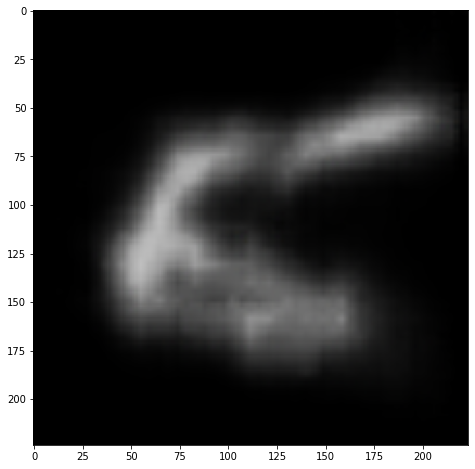

In [3]:
# random sample from latent space
sample = model.sample()[0].permute(1, 2, 0)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

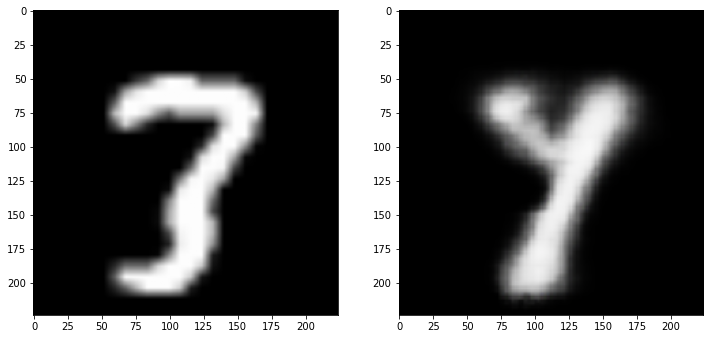

In [4]:
# generate from input
fig, axs = plt.subplots(1, 2)
for batch in val_data_loader:
    if batch[0] is None:
        continue
    if dataset_used in ['MNIST', 'UTD', 'FashionMNIST', 'CIFAR10']:
        img = batch[0].to(device)
    elif dataset_used == 'MPII':
        img = batch['image'].to(device)
        
    img_show = img.squeeze(0).permute(1, 2, 0)
    axs[0].imshow(img_show.cpu().detach().numpy())
    gen = model(img)[0].squeeze(0).permute(1, 2, 0)
    axs[1].imshow(gen.cpu().detach().numpy())
    
    plt.show()
    break

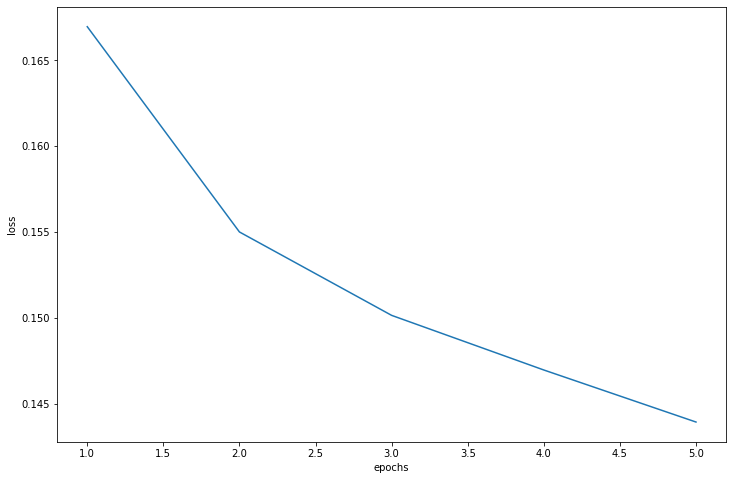

In [5]:
# plot training curve
import json

with open('logs/'+model_name+'.json', 'r') as f:
    losses = json.load(f)

x = range(1, len(losses)+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, losses)
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.show()

In [6]:
# latent space visualization
mus = None
labels = []
for batch in val_data_loader:
    if batch[0] is None:
        continue
    with torch.no_grad():
        if dataset_used in ['MNIST', 'UTD', 'FashionMNIST', 'CIFAR10']:
            img, label = batch[0].to(device), batch[1]
        elif dataset_used == 'MPII':
            img = batch['image'].to(device)
        
        mu, var = model.encode(img)
        if mus is None:
            mus = mu
        else:
            mus = torch.cat((mus, mu), 0)
        labels.append(label)

In [7]:
from sklearn.decomposition import PCA
estimator = PCA(n_components=3) 
pca_mus = estimator.fit_transform(mus.cpu())
print(pca_mus.shape)

(3595, 3)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

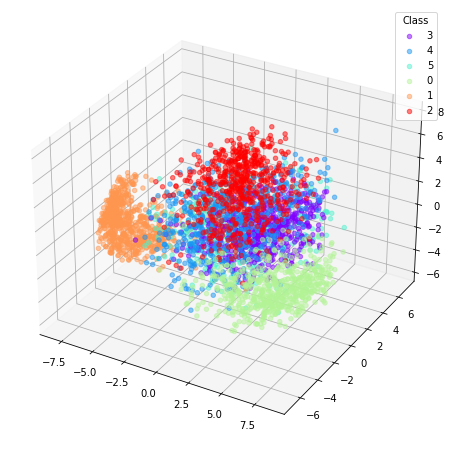

In [8]:
import matplotlib.cm as cm
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_cordinates = {}
y_cordinates = {}
z_cordinates = {}
for mu, label in zip(pca_mus, labels):
    label = int(label)
    xs, ys, zs = x_cordinates.get(label, []),\
                 y_cordinates.get(label, []),\
                 z_cordinates.get(label, [])
    xs.append(mu[0])
    ys.append(mu[1])
    zs.append(mu[2])
    x_cordinates[label], y_cordinates[label], z_cordinates[label] = xs, ys, zs

colors = cm.rainbow(np.linspace(0, 1, len(x_cordinates.keys())))
for i, label in enumerate(x_cordinates.keys()):
    xs, ys, zs = x_cordinates[label], y_cordinates[label], z_cordinates[label]
    color = colors[i]
    ax.scatter(xs, ys, zs, c=color, label=label, alpha=0.5)
    
ax.legend(loc="upper right", title="Class")
plt.show()